In [1]:
# default_exp data.synthetic

# Synthetic Data
> Functions to generate synthetic data for testing purposes

In [2]:
#export
from tsai.imports import *
from tsai.utils import * 
from tsai.data.validation import *

In [3]:
#export
def _get_sample_signals(length=1000, n_sig=10):
    if (isinstance(length, tuple) or isinstance(length, tuple)):
        assert len(length) == 2
        lengths = np.random.randint(*length, n_sig)
    else:
        lengths = [length]*n_sig
        
    all_sig = []
    for i, scale_x in enumerate(2.0*np.pi/100*np.linspace(0.8, 1.2, n_sig)):
        n = lengths[i]
        offset = 2.0*np.pi*random.random()
        sig = np.sin(offset + scale_x*np.arange(n))*np.linspace(1.5, 0.5, n)
        all_sig.append(sig)
        
    if (isinstance(length, tuple) or isinstance(length, tuple)):
        return np.array(all_sig, dtype=object)
    else:
        return np.array(all_sig)

In [4]:
#export
def _get_sample_events(data):
    """Use signal peaks for sample events"""
    results = []
    for sig in data:
        deriv = np.diff(sig)
        peaks = np.logical_and(deriv[:-1]> 0, deriv[1:]<= 0)
        results.append(np.where(peaks)[0])
    return results

In [5]:
#export
def _get_sample_folds(n_sig, n_fold):
    folds = np.array([*range(n_fold)]*((n_sig+n_fold-1)//n_fold))
    np.random.shuffle(folds)
    folds = folds[:n_sig]
    assert len(folds) == n_sig
    return folds

In [6]:
#export
def _get_sample_splits(n_sig, split_pct):
    assert isinstance(split_pct, float) or isinstance(split_pct, tuple) or isinstance(split_pct, list)
    all_indices = [*range(n_sig)]
    random.shuffle(all_indices)
    if isinstance(split_pct, float):
        i_val = int(round(split_pct*n_sig))
        splits = L(sorted(all_indices[i_val:]), sorted(all_indices[:i_val]))
    else:
        assert len(split_pct) == 2
        i_val = int(round(split_pct[0]*n_sig))
        i_test = i_val+int(round(split_pct[0]*n_sig))
        splits = L(sorted(all_indices[i_test:]), sorted(all_indices[:i_val]), sorted(all_indices[i_val:i_test]))
    return splits

In [7]:
#export
def get_sample_data(length=1000, n_sig=10, dims=2, n_fold=None, split_pct=None):
    """ Generates sample data with associated events at local maxima
Inputs:
    length:    Length of individual signals, expressed as int or tuple (min_len, max_len) 
    n_sig:     Number of signals to be generated.
    dims:      Number of dimensions in X array (2 or 3).  If 3, channel dimension will be added, 
    n_fold:    Optional number of folds, signals randomly distributed among folds 
    split_pct: Optional split fractions, expressed as int of train/valid or tuple
               (pct_valid, pct_tst) if train/valid/test
Refurns:
    X:         Synthetic signal data
    y:         Synthetic labels where label is index of row in X
    splits:    Optional splits data if split_pct specified
    folds:     Optional folds data if n_fold specified
    *note: splits and folds are metuallly exclusive

    """
    assert dims in (2,3)
    X = _get_sample_signals(length=length, n_sig=n_sig)
    y = np.array([f'ID{i:06d}'for i in range(n_sig)])
    events = _get_sample_events(X)
    
    if dims==3:
        X = np.expand_dims(X, 1)
        
    if n_fold is not None:
        folds = _get_sample_folds(n_sig, n_fold)
        return X, y, events, folds
    elif split_pct is not None:
        splits = _get_sample_splits(n_sig, split_pct)
        return X, y, events, splits
    else:
        return X, y, events

In [8]:
help(get_sample_data)

Help on function get_sample_data in module __main__:

get_sample_data(length=1000, n_sig=10, dims=2, n_fold=None, split_pct=None)
    Generates sample data with associated events at local maxima
    Inputs:
        length:    Length of individual signals, expressed as int or tuple (min_len, max_len) 
        n_sig:     Number of signals to be generated.
        dims:      Number of dimensions in X array (2 or 3).  If 3, channel dimension will be added, 
        n_fold:    Optional number of folds, signals randomly distributed among folds 
        split_pct: Optional split fractions, expressed as int of train/valid or tuple
                   (pct_valid, pct_tst) if train/valid/test
    Refurns:
        X:         Synthetic signal data
        y:         Synthetic labels where label is index of row in X
        splits:    Optional splits data if split_pct specified
        folds:     Optional folds data if n_fold specified
        *note: splits and folds are metuallly exclusive



#### Verify correct number of outputs based on options

In [9]:
test_eq(len(get_sample_data(length=1000, n_sig=3)), 3)
test_eq(len(get_sample_data(length=1000, n_sig=3, n_fold=2)), 4)
test_eq(len(get_sample_data(length=1000, n_sig=3, split_pct=0.2)), 4)
test_eq(len(get_sample_data(length=1000, n_sig=3, split_pct=(0.2, 0.1))), 4)

#### Show sample folds and splits and verify lengths

In [10]:
n_sig=5
_,_,_,folds = get_sample_data(length=1000, n_sig=n_sig, n_fold=2)
_,_,_,split2 = get_sample_data(length=1000, n_sig=n_sig, split_pct=0.2)  # train/valid
_,_,_,split3 = get_sample_data(length=1000, n_sig=n_sig, split_pct=(0.2, 0.1)) # train/valid/test
test_eq(len(folds), n_sig)
test_eq(len(split2), 2)
test_eq(len(split3), 3)
print(type(folds), type(split2), type(split3))
folds, split2, split3

<class 'numpy.ndarray'> <class 'fastcore.foundation.L'> <class 'fastcore.foundation.L'>


(array([1, 0, 0, 0, 1]), (#2) [[0, 1, 3, 4],[2]], (#3) [[0, 3, 4],[2],[1]])

#### Show signals with events - fixed signal length

X:(3, 1000)  y:3  events:3


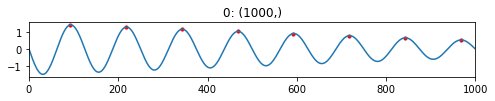

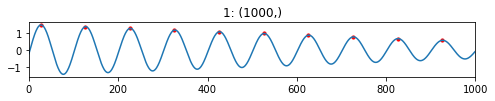

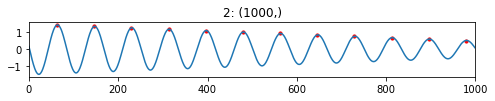

In [11]:
X, y, events = get_sample_data(length=1000, n_sig=3)
print(f'X:{X.shape}  y:{len(y)}  events:{len(events)}')
for i, sig in enumerate(X):
    plt.figure(figsize=(8, 1))
    plt.title(f'{i}: {sig.shape}')
    plt.plot(np.arange(len(sig)), sig)
    plt.scatter(events[i], sig[events[i]], c='r', s=10)
    plt.xlim(0, len(sig))
    plt.show()

#### Show signals with events - include dinm for channel

X:(2, 1, 1000)  y:2  events:2


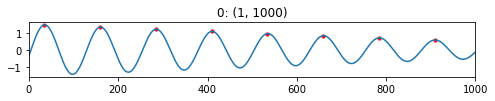

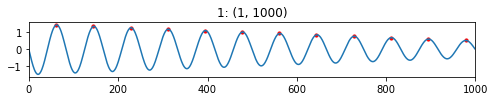

In [12]:
X, y, events = get_sample_data(length=1000, n_sig=2, dims=3)
print(f'X:{X.shape}  y:{len(y)}  events:{len(events)}')
for i, sig in enumerate(X):
    plt.figure(figsize=(8, 1))
    plt.title(f'{i}: {sig.shape}')
    plt.plot(np.arange(sig.shape[-1]), sig[0])
    plt.scatter(events[i], sig[0,events[i]], c='r', s=10)
    plt.xlim(0, sig.shape[-1])
    plt.show()

#### Show signals with events - variable signal length

X:(3,)  y:3  events:3


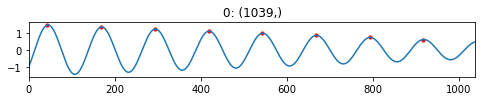

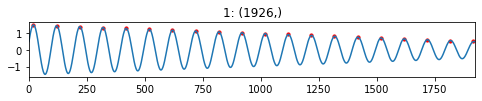

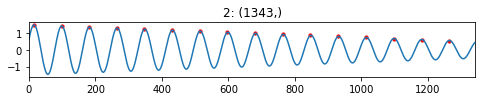

In [13]:
X, y, events = get_sample_data(length=(1000, 2000), n_sig=3)
print(f'X:{X.shape}  y:{len(y)}  events:{len(events)}')
for i, sig in enumerate(X):
    plt.figure(figsize=(8,1))
    plt.title(f'{i}: {sig.shape}')
    plt.plot(np.arange(len(sig)), sig)
    plt.scatter(events[i], sig[events[i]], c='r', s=10)
    plt.xlim(0, len(sig))
    plt.show()